*WebMD* Drug Reviews Dataset;
Dataset of user reviews on various drugs;
https://www.kaggle.com/rohanharode07/webmd-drug-reviews-dataset

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import xgboost as xgb
from tqdm import tqdm
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

import os
import string
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Loading the dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
dataframe = pd.read_csv("/content/drive/My Drive/nlp project dataset/webmd.csv")

In [5]:
dataframe.head()

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount
0,75 or over,Stuffy Nose,9/21/2014,25dph-7.5peh,146724,5,5,I'm a retired physician and of all the meds I ...,5,Male,"Drowsiness, dizziness , dry mouth /nose/thro...",0
1,25-34,Cold Symptoms,1/13/2011,25dph-7.5peh,146724,5,5,cleared me right up even with my throat hurtin...,5,Female,"Drowsiness, dizziness , dry mouth /nose/thro...",1
2,65-74,Other,7/16/2012,warfarin (bulk) 100 % powder,144731,2,3,why did my PTINR go from a normal of 2.5 to ov...,3,Female,,0
3,75 or over,Other,9/23/2010,warfarin (bulk) 100 % powder,144731,2,2,FALLING AND DON'T REALISE IT,1,Female,,0
4,35-44,Other,1/6/2009,warfarin (bulk) 100 % powder,144731,1,1,My grandfather was prescribed this medication ...,1,Male,,1


Exploring and visualizing the data

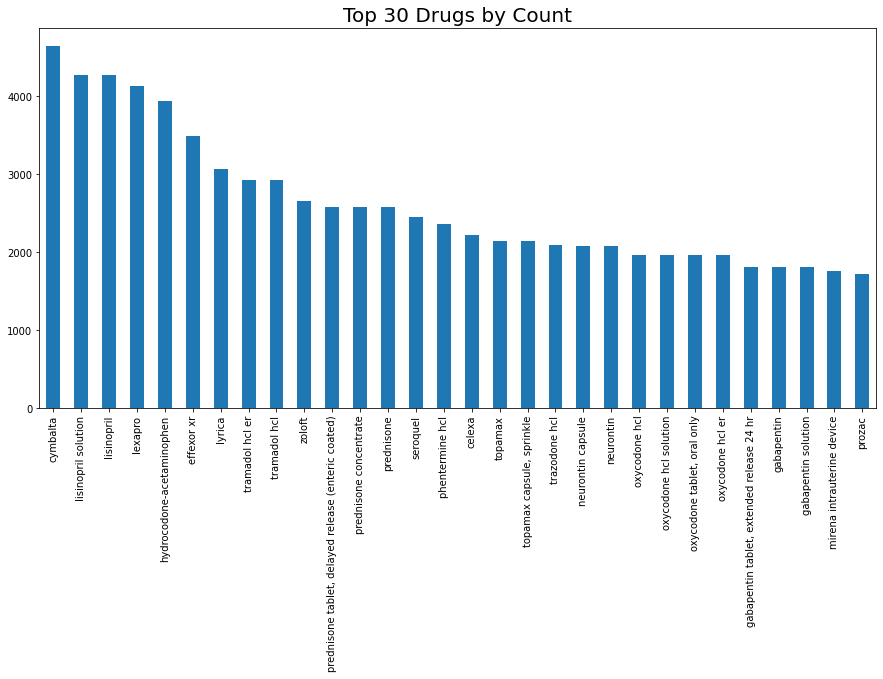

In [6]:
top_30_drugs = dataframe.Drug.value_counts()[:30]
plt.figure(figsize = (15,7))
top_30_drugs.plot(kind = 'bar');
plt.title('Top 30 Drugs by Count',fontsize = 20);

After the top 30 different drugs used most, let's have a look at the top 30 conditions as problems which people face.

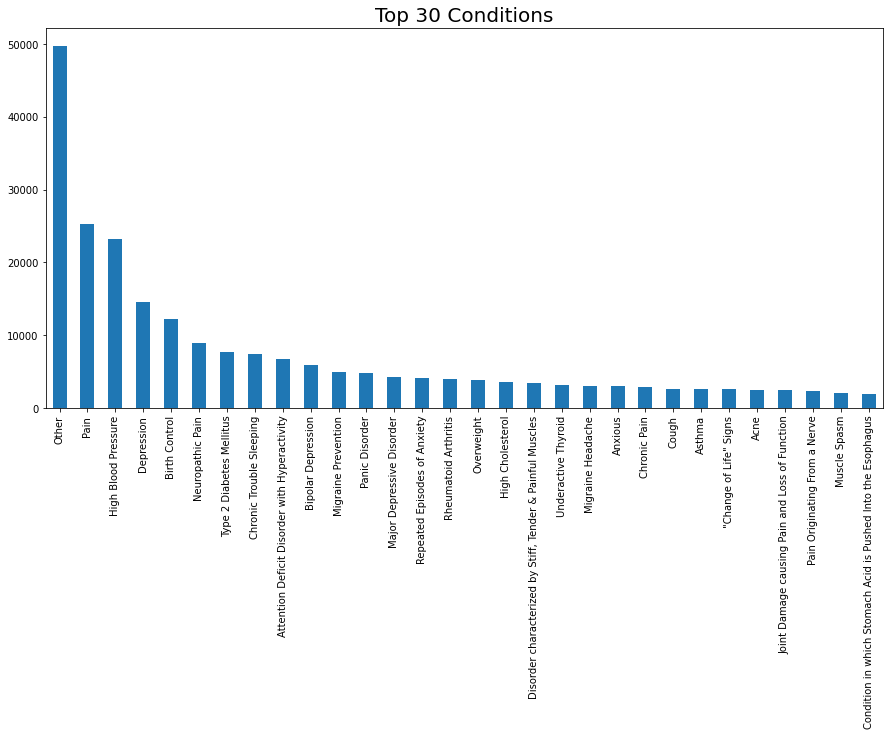

In [7]:
top_30_problems = dataframe.Condition.value_counts()[:30]
plt.figure(figsize = (15,7))
top_30_problems.plot(kind = 'bar');
plt.title('Top 30 Conditions',fontsize = 20);

The topmost condition is unlisted or in other words apparently multiple conditions treated with the medications which are reviewed are listed by the name 'Other'. 

Comparisson between the unique number of unique IDs of drugs and the length of the whole dataset to see what is the ratio between medication ids and the whole dataframe




In [8]:
print("unique values count of dataset : " ,len(set(dataframe['DrugId'].values)))
print("length of dataset : " ,dataframe.shape[0])

unique values count of dataset :  6572
length of dataset :  362806


The name of the drug is related to condition.

Text(0.5, 1.0, 'Top 20 : The number of drugs per condition.')

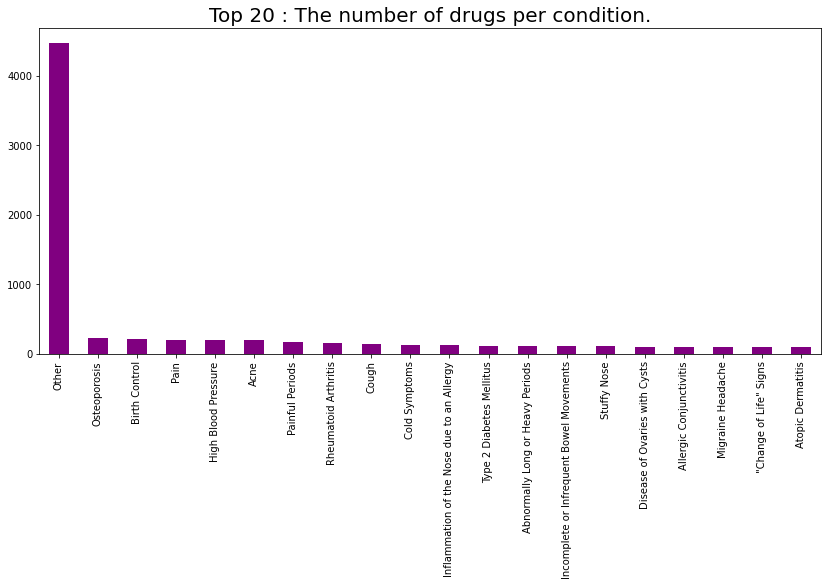

In [9]:
condition_drug = dataframe.groupby(['Condition'])['Drug'].nunique().sort_values(ascending=False)
condition_drug[0:20].plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Top 20 : The number of drugs per condition.", fontsize = 20)

The reason there are the most medications used for the condition named 'Other' is that there are more than one condition behind this name. The guess is that the patient out of any reason has not listed the specific name of the condition, but still has given her/his opinion about the medication she/he has used for  treatment.

Text(0.5, 1.0, 'Bottom 20 : The number of drugs per condition.')

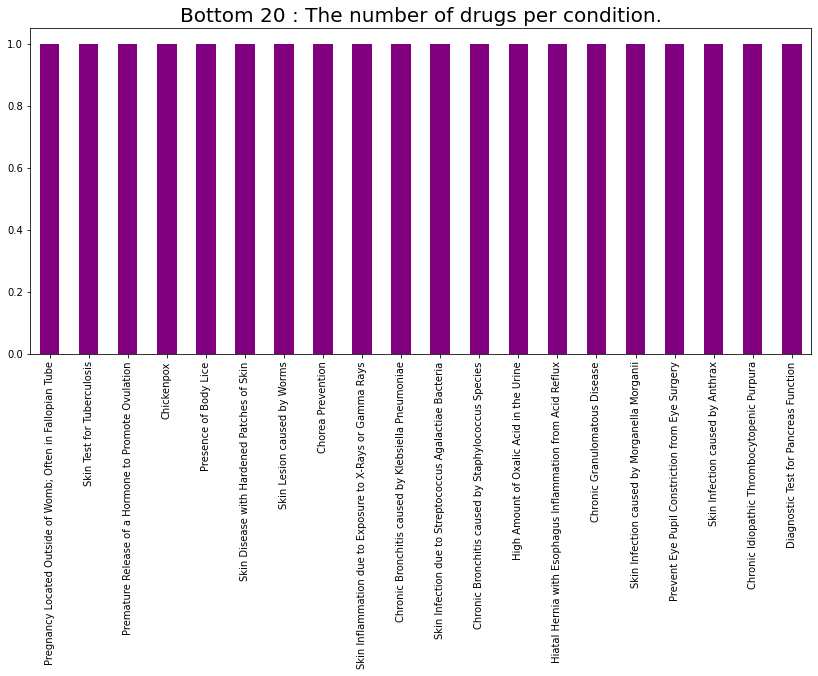

In [10]:
condition_drug = dataframe.groupby(['Condition'])['Drug'].nunique().sort_values(ascending=False)
condition_drug[condition_drug.shape[0]-20:condition_drug.shape[0]].plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Bottom 20 : The number of drugs per condition.", fontsize = 20)

Let's have a look at a random review:

In [11]:
dataframe['Reviews'][10]


'Excellent in reducing inlamation associated with osteo-arthritis!'

WordCloud of the reviews

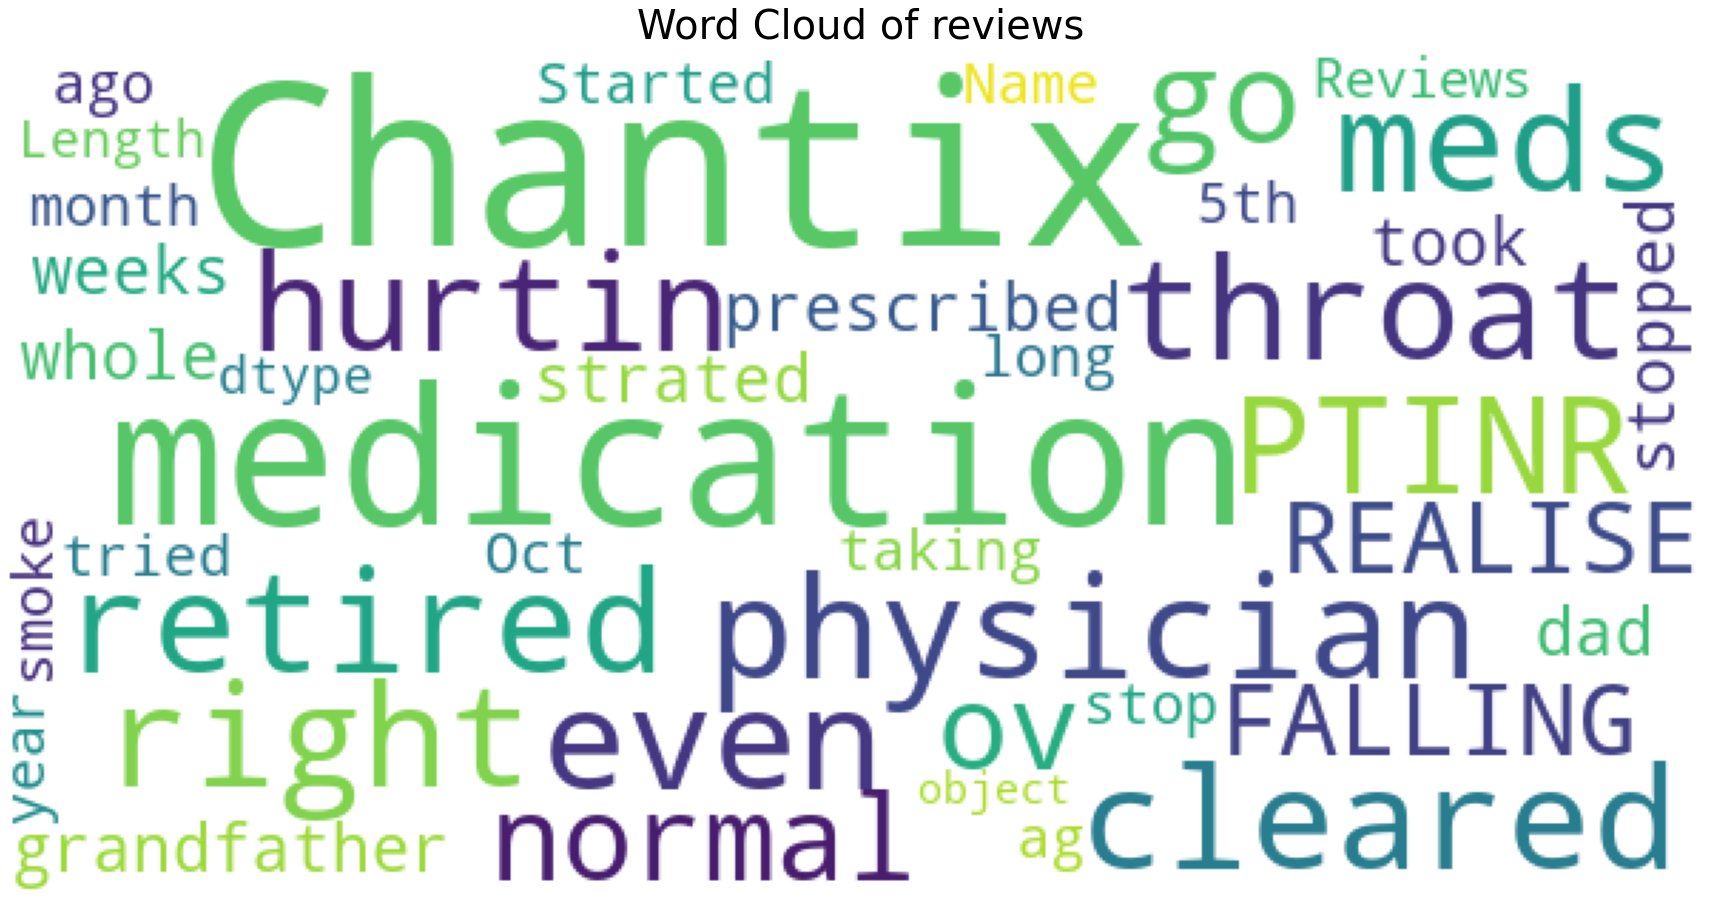

In [12]:
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=400, max_font_size=80, figure_size=(24.0,16.0), 
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)

    wordcloud = WordCloud(background_color='white',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=600, 
                    height=300,
                    mask = mask)
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    if image_color:
        image_colors = ImageColorGenerator(mask);
        plt.imshow(wordcloud.recolor(color_func=image_colors), interpolation="bilinear");
        plt.title(title, fontdict={'size': title_size,  
                                  'verticalalignment': 'bottom'})
    else:
        plt.imshow(wordcloud);
        plt.title(title, fontdict={'size': title_size, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()  
    
plot_wordcloud(dataframe['Reviews'], title="Word Cloud of reviews")

Diving into the ratings

In [0]:
from collections import defaultdict
dataframe_3_5_satisfaction = dataframe[dataframe["Satisfaction"]>2].astype(str)
dataframe_1_3_satisfaction = dataframe[dataframe["Satisfaction"]<3].astype(str)

In [14]:
dataframe_3_5_satisfaction["Reviews"].head()


0    I'm a retired physician and of all the meds I ...
1    cleared me right up even with my throat hurtin...
2    why did my PTINR go from a normal of 2.5 to ov...
5                  help heart condition operation well
7    I have take this for 5 years age 45-50 to prev...
Name: Reviews, dtype: object

Text(0.5, 1.0, 'Count of satisfaction rating values - ease of use = pink; effectiveness = orange; satisfaction = green;')

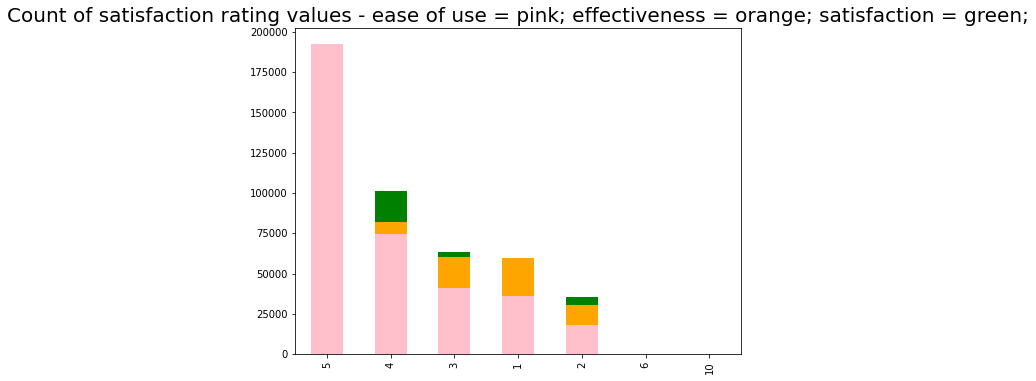

In [15]:
#Satisfaction
rating = dataframe['Satisfaction'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
#Effectiveness
rating_effectiveness = dataframe['Effectiveness'].value_counts().sort_values(ascending=False)
rating_effectiveness.plot(kind="bar", figsize = (12,4), fontsize = 10,color="orange")
#EaseOfUse
rating_EaseOfUse = dataframe['EaseofUse'].value_counts().sort_values(ascending=False)
rating_EaseOfUse.plot(kind="bar", figsize = (8,6), fontsize = 10,color="pink")

plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of satisfaction rating values - ease of use = pink; effectiveness = orange; satisfaction = green;", fontsize = 20)

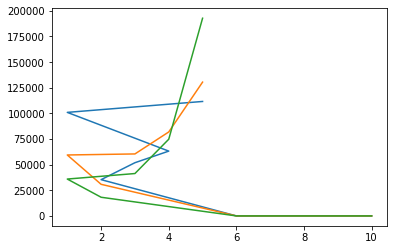

In [16]:
#Satisfaction
satisfaction = dataframe['Satisfaction'].value_counts().sort_values(ascending=False)
#rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
#Effectiveness
effectiveness = dataframe['Effectiveness'].value_counts().sort_values(ascending=False)
#rating_effectiveness.plot(kind="bar", figsize = (12,4), fontsize = 10,color="orange")
#EaseOfUse
EaseOfUse = dataframe['EaseofUse'].value_counts().sort_values(ascending=False)
#rating_EaseOfUse.plot(kind="bar", figsize = (8,6), fontsize = 10,color="pink")
satisfaction.plot()
effectiveness.plot()
EaseOfUse.plot()

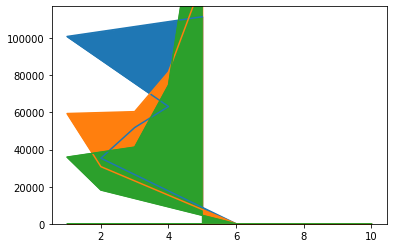

In [17]:
from pandas.plotting import scatter_matrix
satisfaction = dataframe['Satisfaction'].value_counts().sort_values(ascending=False)
effectiveness = dataframe['Effectiveness'].value_counts().sort_values(ascending=False)
EaseOfUse = dataframe['EaseofUse'].value_counts().sort_values(ascending=False)

satisfaction.plot.area()
effectiveness.plot.area()
EaseOfUse.plot.area()
#scatter_matrix(dataframe['Effectiveness'].value_counts().sort_values(ascending=False))
#scatter_matrix(dataframe['EaseofUse'].value_counts().sort_values(ascending=False))

Text(0.5, 1.0, 'Count of effectiveness rating values')

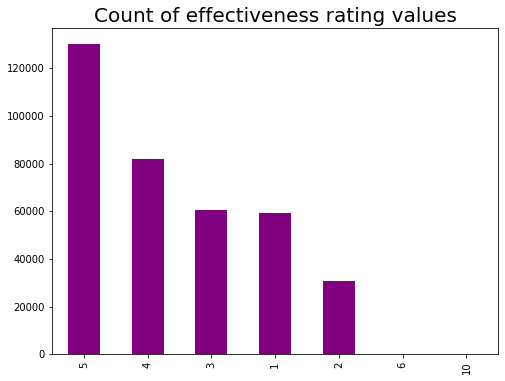

In [18]:
rating = dataframe['Effectiveness'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (8,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of effectiveness rating values", fontsize = 20)

For the effectiveness of the particular drugs people gave all the possible rating values (from 1 to 5), but With this, we can see that the percentage of positives is higher than negative, and twice as much.

Text(0.5, 1.0, "Count of 'easy to use' rating values")

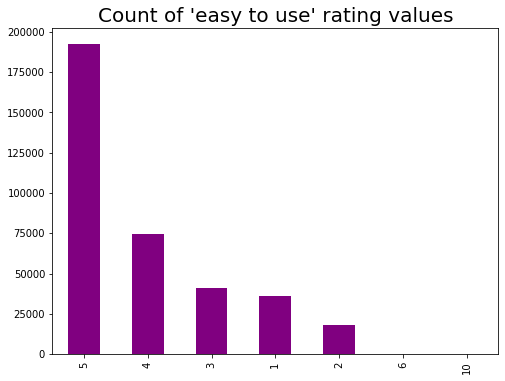

In [19]:
rating = dataframe['EaseofUse'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (8,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of 'easy to use' rating values", fontsize = 20)

For the 'easy to use' rating people were more positive than negative, as viewed on the plot above.

Text(0.5, 1.0, 'Count of satisfaction rating values')

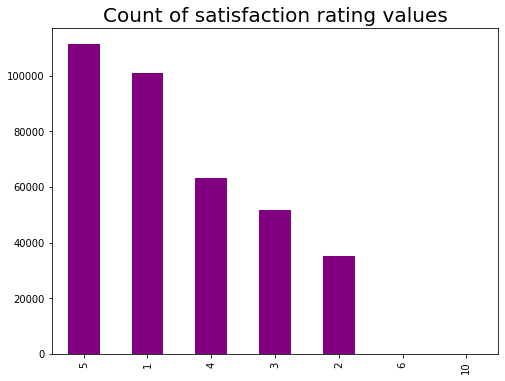

In [20]:
rating = dataframe['Satisfaction'].value_counts().sort_values(ascending=False)
rating.plot(kind="bar", figsize = (8,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Count of satisfaction rating values", fontsize = 20)

We can notice that the people were pretty much the same amount subjectively satisfied with the medication as they were not. The extremes 5 and 1 have almost same values.

Next, we can take a look at the column that represents date of the review.

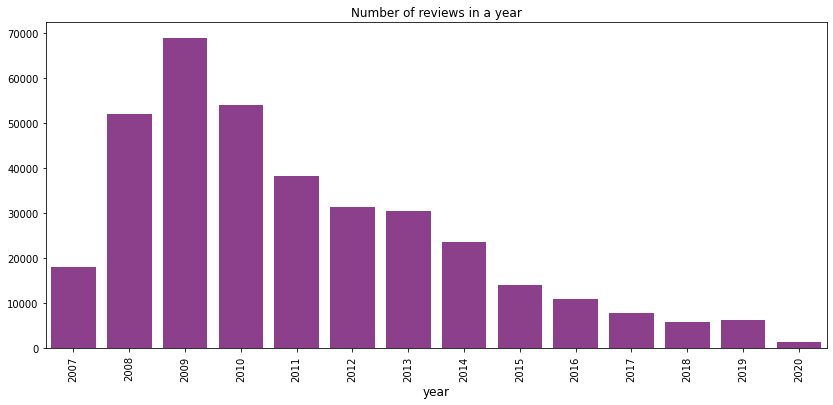

In [21]:
dataframe['Date'] = pd.to_datetime(dataframe['Date'], errors='coerce')
cnt_srs = dataframe['Date'].dt.year.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='purple')
plt.xticks(rotation='vertical')
plt.xlabel('year', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in a year")
plt.show()

We can see that we have data from 2007 to March 2020. And most reviews were given in 2009, least in 2020 which may be a result that have passed only 3 months.

Mean **Satisfaction** rating in a year

Text(0.5, 1.0, "Mean 'satisfaction' rating by year")

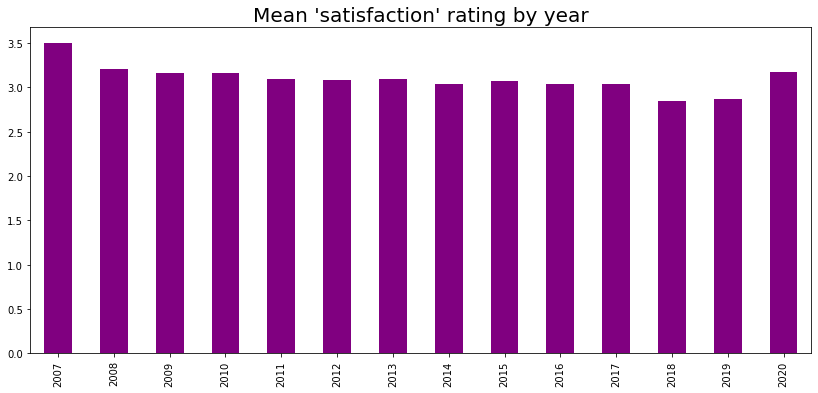

In [22]:
dataframe['year'] = dataframe['Date'].dt.year
rating = dataframe.groupby('year')['Satisfaction'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean 'satisfaction' rating by year", fontsize = 20)


Mean **Effectiveness** rating by year

Text(0.5, 1.0, "Mean 'effectiveness' rating by year")

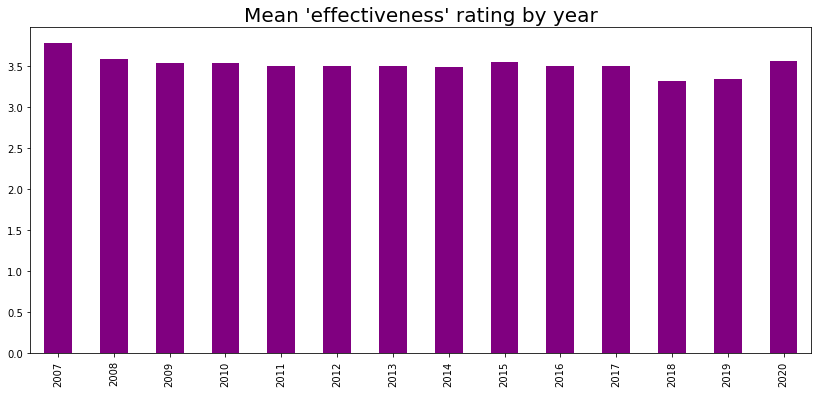

In [23]:
dataframe['year'] = dataframe['Date'].dt.year
rating = dataframe.groupby('year')['Effectiveness'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean 'effectiveness' rating by year", fontsize = 20)

Mean **Easy to use** rating by year

Text(0.5, 1.0, "Mean 'easy to use' rating by year")

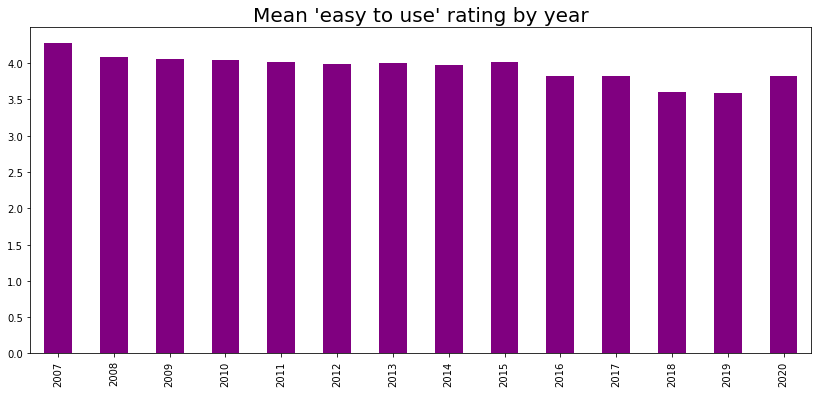

In [24]:
dataframe['year'] = dataframe['Date'].dt.year
rating = dataframe.groupby('year')['EaseofUse'].mean()
rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
plt.xlabel("", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Mean 'easy to use' rating by year", fontsize = 20)

Number of reviews in a month

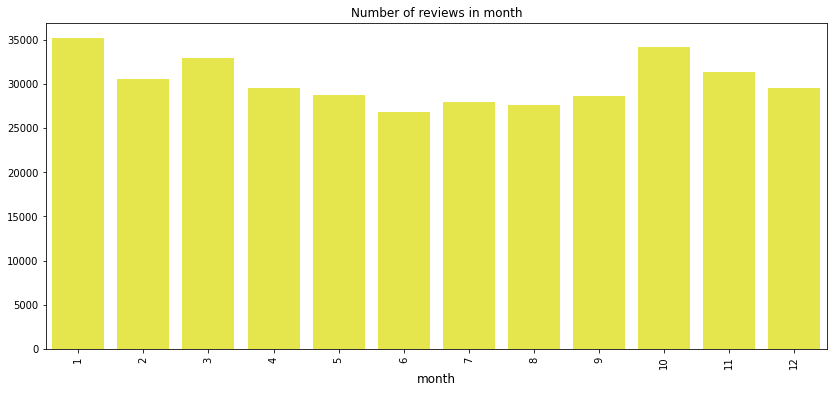

In [25]:
cnt_srs = dataframe['Date'].dt.month.value_counts()
cnt_srs = cnt_srs.sort_index()
plt.figure(figsize=(14,6))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color='yellow')
plt.xticks(rotation='vertical')
plt.xlabel('month', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Number of reviews in month")
plt.show()

Most reviews were given in January

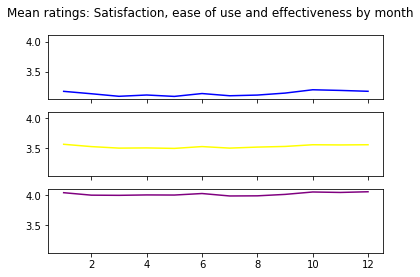

In [26]:
dataframe['month'] = dataframe['Date'].dt.month
rating = dataframe.groupby('month')['Satisfaction'].mean()
#rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="purple")
#plt.xlabel("", fontsize = 20)
#plt.ylabel("", fontsize = 20)
#plt.title("Mean 'Satisfaction' rating in month", fontsize = 20)

dataframe['month'] = dataframe['Date'].dt.month
rating2 = dataframe.groupby('month')['Effectiveness'].mean()
#rating2.plot(kind="bar", figsize = (14,6), fontsize = 10,color="yellow")
#plt.xlabel("", fontsize = 20)
#plt.ylabel("", fontsize = 20)
#plt.title("Mean 'Effectiveness' rating in month", fontsize = 20)


dataframe['month'] = dataframe['Date'].dt.month
rating3 = dataframe.groupby('month')['EaseofUse'].mean()
#rating3.plot(kind="bar", figsize = (14,6), fontsize = 10,color="blue")
#plt.xlabel("", fontsize = 20)
#plt.ylabel("", fontsize = 20)
#plt.title("Mean 'ease of use' rating in month", fontsize = 20)

fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Mean ratings: Satisfaction, ease of use and effectiveness by month')
axs[0].plot(rating,"",color='blue')
axs[1].plot(rating2, '',color='yellow')
axs[2].plot(rating3, "",color='purple')

We can check whether the day of the week affects the rating like salary day, but it does not make a big difference.

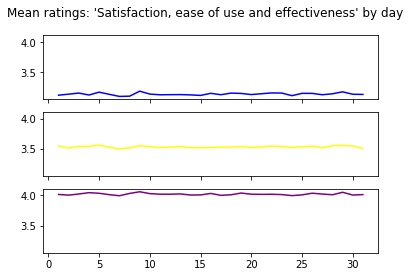

In [27]:
dataframe['day'] = dataframe['Date'].dt.day
rating = dataframe.groupby('day')['Satisfaction'].mean()
#rating.plot(kind="bar", figsize = (14,6), fontsize = 10,color="green")
#plt.xlabel("", fontsize = 20)
#plt.ylabel("", fontsize = 20)
#plt.title("Mean rating in day", fontsize = 20)
rating2 = dataframe.groupby('day')['Effectiveness'].mean()
rating3 = dataframe.groupby('day')['EaseofUse'].mean()
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle("Mean ratings: 'Satisfaction, ease of use and effectiveness' by day")
axs[0].plot(rating,"",color='blue')
axs[1].plot(rating2, '',color='yellow')
axs[2].plot(rating3, "",color='purple')

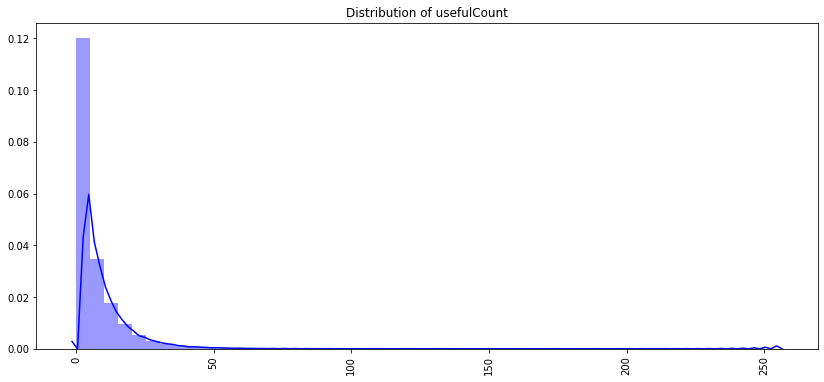

In [28]:
plt.figure(figsize=(14,6))
sns.distplot(dataframe["UsefulCount"].dropna(),color="blue")
plt.xticks(rotation='vertical')
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.title("Distribution of usefulCount")
plt.show()

In [29]:
dataframe["UsefulCount"].describe()


count    362806.000000
mean          6.744916
std           9.324240
min           0.000000
25%           1.000000
50%           4.000000
75%           9.000000
max         255.000000
Name: UsefulCount, dtype: float64

The difference between min and max is 255 (255-0) which is a big difference. The standard deviation is 9.32.

Missing values

Text(0.5, 1.0, 'Total Missing Value ')

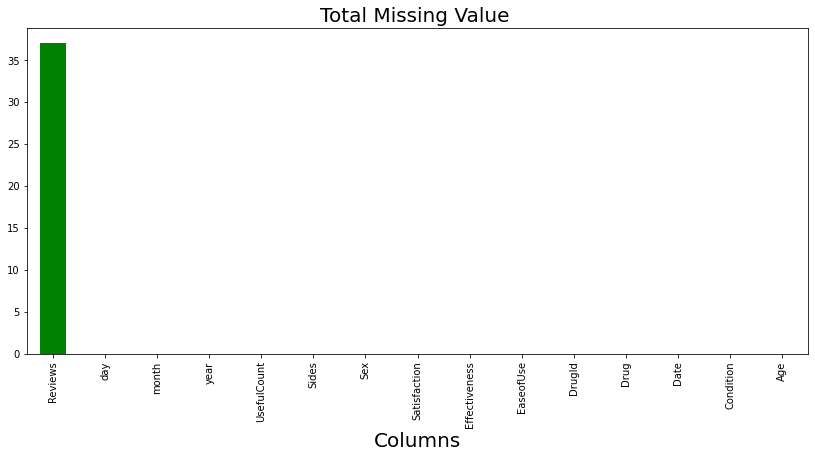

In [30]:
percent = (dataframe.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

In [31]:
print("Missing value (%):", dataframe.isna().mean().round(4)*100)


Missing value (%): Age              0.00
Condition        0.00
Date             0.00
Drug             0.00
DrugId           0.00
EaseofUse        0.00
Effectiveness    0.00
Reviews          0.01
Satisfaction     0.00
Sex              0.00
Sides            0.00
UsefulCount      0.00
year             0.00
month            0.00
day              0.00
dtype: float64


There is an insignificant shortage of values in the Reviews column.

In [32]:
print("Missing value (%):", 40/dataframe.shape[0] *100)


Missing value (%): 0.01102517598937173


We can probably delete the missing values because their number is so small, and the procentage is 0.01%.

In [0]:
dataframe = dataframe.dropna(axis=0)


Text(0.5, 1.0, 'Total Missing Value ')

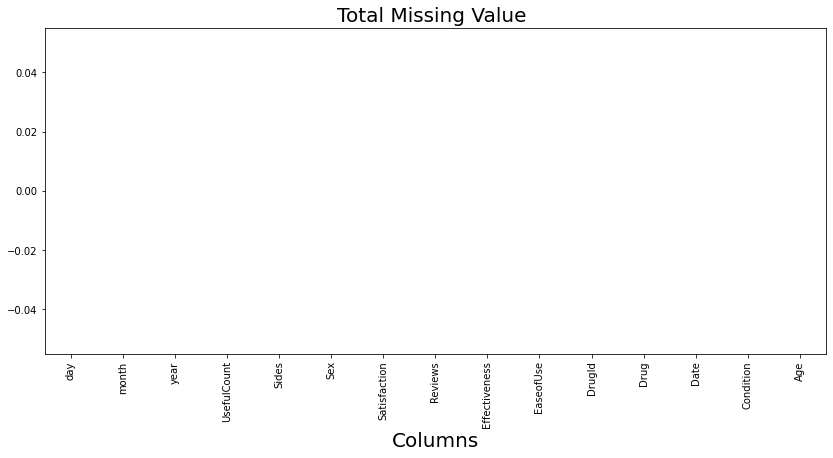

In [34]:
dataframe.reset_index()
percent = (dataframe.isnull().sum()).sort_values(ascending=False)
percent.plot(kind="bar", figsize = (14,6), fontsize = 10, color='green')
plt.xlabel("Columns", fontsize = 20)
plt.ylabel("", fontsize = 20)
plt.title("Total Missing Value ", fontsize = 20)

Now we see that there are no missing values left.

In [35]:
dataframe.Drug.unique().size

7093

In [36]:
# Sorting top 10 conditions
conditions = dataframe.Condition.value_counts().sort_values(ascending=False)
conditions[:10]

Other                                            49758
Pain                                             25225
High Blood Pressure                              23271
Depression                                       14509
Birth Control                                    12253
Neuropathic Pain                                  8988
Type 2 Diabetes Mellitus                          7647
Chronic Trouble Sleeping                          7406
Attention Deficit Disorder with Hyperactivity     6801
Bipolar Depression                                5946
Name: Condition, dtype: int64

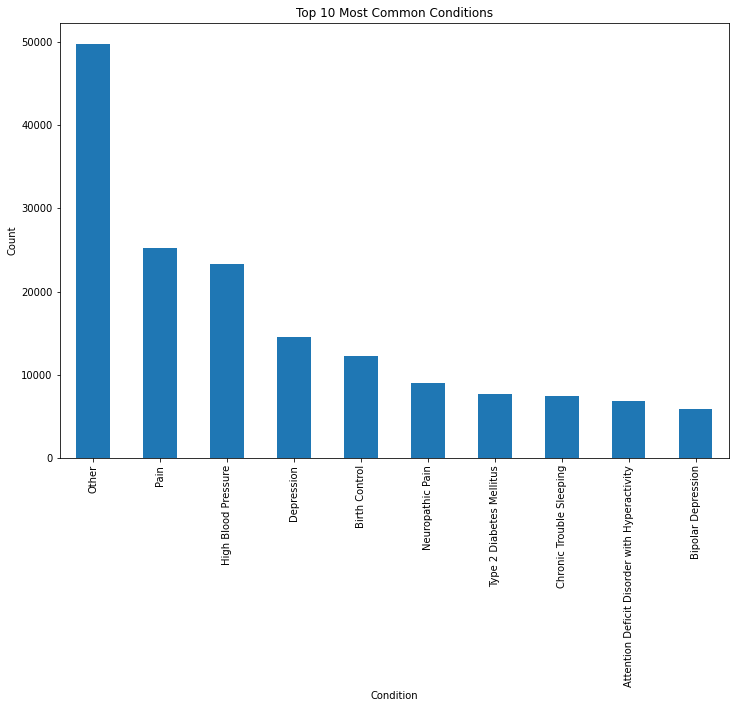

In [37]:
plt.rcParams['figure.figsize'] = [12, 8]
conditions[:10].plot(kind='bar')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');

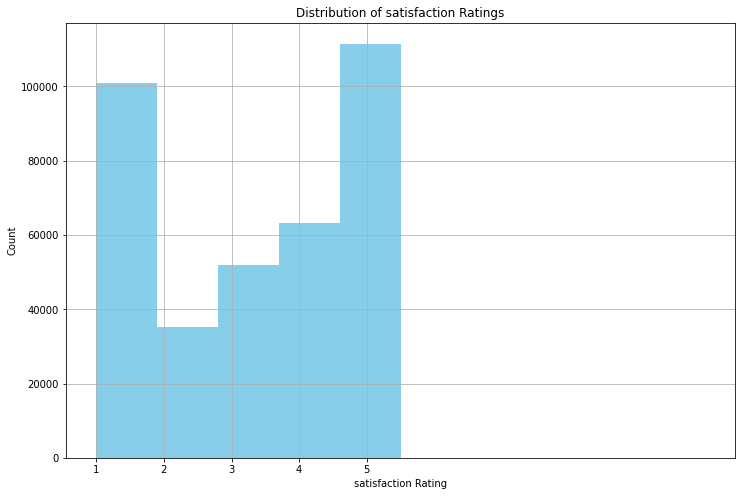

In [38]:
dataframe.Satisfaction.hist(color='skyblue')
plt.title('Distribution of satisfaction Ratings')
plt.xlabel('satisfaction Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 6)]);

This distribution illustrates that people generally write reviews for drugs they really like (or those that they really dislike). There are fewer middle ratings as compared to extreme ratings.

Text(0, 0.5, 'Count')

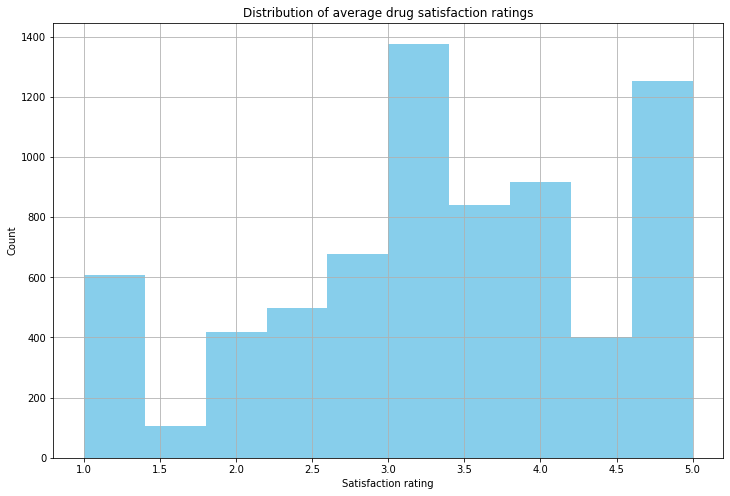

In [39]:
rating_avgs = (dataframe['Satisfaction'].groupby(dataframe['Drug']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Distribution of average drug satisfaction ratings')
plt.xlabel('Satisfaction rating')
plt.ylabel('Count')

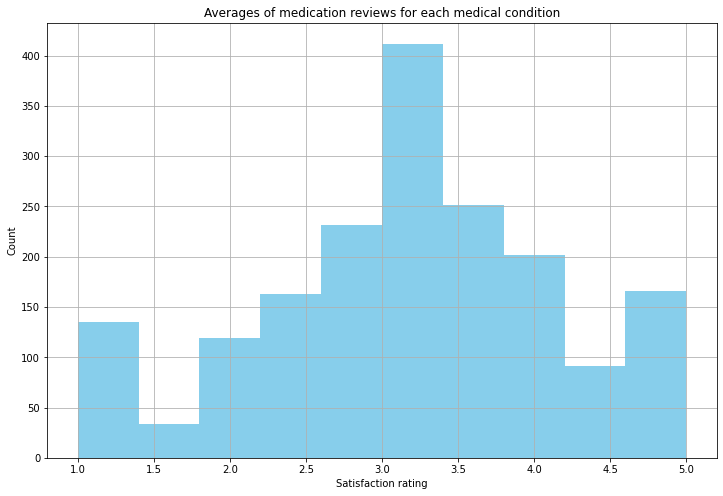

In [40]:
rating_avgs = (dataframe['Satisfaction'].groupby(dataframe['Condition']).mean())
rating_avgs.hist(color='skyblue')
plt.title('Averages of medication reviews for each medical condition')
plt.xlabel('Satisfaction rating')
plt.ylabel('Count')
plt.show()

Satisfaction rating vs usefulness

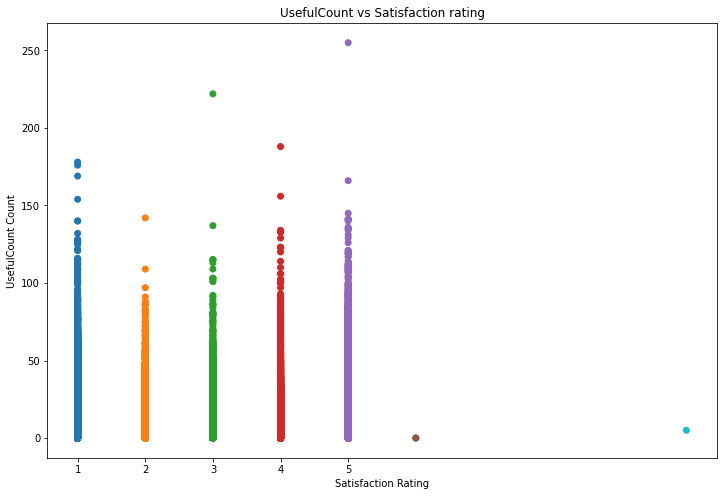

In [41]:
# Is satisfaction rating correlated with usefulness of the review?
plt.scatter(dataframe.Satisfaction, dataframe.UsefulCount , c=dataframe.Satisfaction.values, cmap='tab10')
plt.title('UsefulCount vs Satisfaction rating')
plt.xlabel('Satisfaction Rating')
plt.ylabel('UsefulCount Count')
plt.xticks([i for i in range(1, 6)]);

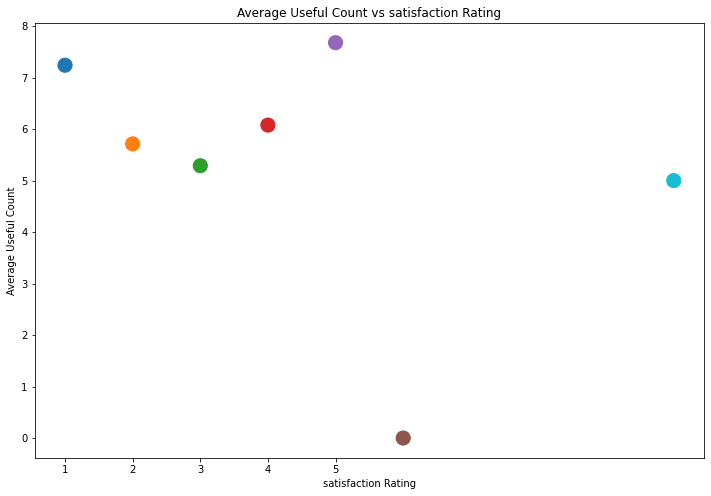

In [42]:
# Create a list (cast into an array) containing the average usefulness for given ratings
use_ls = []

for i in range(1, 11):
    use_ls.append([i, np.sum(dataframe[dataframe.Satisfaction == i].UsefulCount) / np.sum([dataframe.Satisfaction == i])])
    
use_arr = np.asarray(use_ls)
plt.scatter(use_arr[:, 0], use_arr[:, 1], c=use_arr[:, 0], cmap='tab10', s=200)
plt.title('Average Useful Count vs satisfaction Rating')
plt.xlabel('satisfaction Rating')
plt.ylabel('Average Useful Count')
plt.xticks([i for i in range(1, 6)]);

Looks like people have voted more useful the reviews that have extreme values for satisfaction rating. So what makes a review useful? Let's have a look:

In [43]:
# Sort train dataframe from most to least useful
useful_train = dataframe.sort_values(by='UsefulCount', ascending=False)
useful_train.iloc[:10]

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,year,month,day
148220,65-74,Other,2008-01-11,"reclast bottle, infusion",148235,5,5,I have been unable to take any of the osteopor...,5,Female,"Nausea , tiredness, flu -like symptoms (e.g.,...",255,2008,1,11
235462,65-74,Breast Cancer,2015-01-13,anastrozole,1555,5,5,I was diagnosed with with a well differentiate...,3,Female,"Hot flashes , headache , trouble sleeping , ...",222,2015,1,13
286896,35-44,Pain,2007-09-19,hydrocodone-acetaminophen,251,5,4,I have cronic back pain due to an injury. I ha...,4,Female,"Nausea , vomiting , constipation , lighthea...",188,2007,9,19
109227,55-64,Osteoporosis,2015-06-04,prolia syringe,154218,1,1,Was unable to tolorate Fasomax or Actonel. Si...,1,Female,,178,2015,6,4
109223,55-64,Osteoporosis,2015-06-04,prolia syringe,154218,1,1,Pasta girl here again: Forgot to mention when ...,1,Female,,176,2015,6,4
108939,65-74,Decreased Bone Mass Following Menopause,2010-11-22,prolia syringe,154218,1,2,"Pain worse than I've ever had, skin aged and l...",1,Female,,169,2010,11,22
251228,45-54,Attention Deficit Disorder with Hyperactivity,2008-10-10,adderall,63163,5,5,"I am a 48 y.o university professor, - after y...",5,Male,"Loss of appetite, weight loss , dry mouth , ...",166,2008,10,10
211670,35-44,Inability to have an Erection,2007-10-07,viagra,7417,4,5,Very effective. Take without food to help abs...,4,Male,"Dizziness , headache , flushing, or stomach ...",156,2007,10,7
34701,25-34,Depression,2007-11-04,lexapro,63990,5,3,"The doctors don't tell you this, or maybe most...",1,Female,"Nausea , dry mouth , trouble sleeping , con...",154,2007,11,4
315176,45-54,Major Depressive Disorder,2016-02-24,cymbalta,91491,5,5,I just started Cymbalta yesterday for the seco...,5,Female,"Nausea , dry mouth , constipation , loss of ...",145,2016,2,24


In [44]:
#top 3 most useful reviews
for i in useful_train.Reviews.iloc[:3]:
    print(i, '\n')

I have been unable to take any of the osteoporosus drugs for the past several years.  Reclast is working for me both as an easier application, once a year, and better health.  One thing I have noticed is that my fingernails no longer break and are becoming hard.  The same with my toenails.  I took Reclast 2 months ago and so far so good.  My veins are very tiny and hard to find so I take the IV in the chemo room at my local doctors clinic.  Not bad at all.  I also seem to have more energy.  Perhaps it's a release from anxiety that I'm not going to become a hunched over old lady.   

I was diagnosed with with a well differentiated grade 1, stage 2, infiltrating mammary ductul carcinoma breast cancer. This meant it was a mixture of invasive ductal and lobular carcinomas and it was a fast-growing and aggressive Invasive cancer.  When starting this medication 4 years ago, I was told it would cause hot flashes, bone pain, etc.  I was also told if I could tolerate all the side effects, it wo

In [45]:
#3 of the least useful reviews
for i in useful_train.Reviews.iloc[-3:]:
    print(i, '\n')

Died twice and resurrected back. Lol! Jk I’m just trying to distract myself from this horrible pain. Drink a lot of water! This will hurt but it’ll pass. Just don’t take it before going to work.  

I'm 14 and because I've been stopped up and I hadn't used the bathroom enough in the papst few days my doctor recommended me this and I'm currently crying and I've been puking from the pain of this medicine although eventually it allows me to empty my Bowel its WAY too painful and I'm not okay with being up at 1 am with this kinda pain 

Sever side effects, pain in the eyes. 



In [46]:
dataframe.describe(include ='all')

,Age,Condition,Date,Drug,DrugId,EaseofUse,Effectiveness,Reviews,Satisfaction,Sex,Sides,UsefulCount,year,month,day
count,362769,362769,362769,362769,362769.000000,362769.000000,362769.000000,362769,362769.000000,362769,362769,362769.000000,362769.000000,362769.000000,362769.000000
unique,12,1805,4524,7093,NaN,NaN,NaN,250167,NaN,3,1651,NaN,NaN,NaN,NaN
top,45-54,Other,2007-10-29 00:00:00,cymbalta,NaN,NaN,NaN,,NaN,Female,,NaN,NaN,NaN,NaN
freq,80032,49758,404,4648,NaN,NaN,NaN,41824,NaN,238203,17454,NaN,NaN,NaN,NaN
first,NaN,NaN,2007-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2020-03-07 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,36880.251904,4.019839,3.532060,NaN,3.135362,NaN,NaN,6.745546,2011.010456,6.427862,15.808661
std,NaN,NaN,NaN,NaN,52624.930699,1.317727,1.455974,NaN,1.611122,NaN,NaN,9.324502,2.889873,3.535188,8.793063
min,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,NaN,1.000000,NaN,NaN,0.000000,2007.000000,1.000000,1.000000
25%,NaN,NaN,NaN,NaN,4896.000000,3.000000,3.000000,NaN,1.000000,NaN,NaN,1.000000,2009.000000,3.000000,8.000000


In [47]:
dataframe.groupby('Condition')['Drug'].nunique().sort_values(ascending=False).head(20)

Condition
Other                                         4469
Osteoporosis                                   229
Birth Control                                  204
Pain                                           202
High Blood Pressure                            200
Acne                                           197
Painful Periods                                161
Rheumatoid Arthritis                           148
Cough                                          137
Cold Symptoms                                  129
Inflammation of the Nose due to an Allergy     122
Type 2 Diabetes Mellitus                       117
Abnormally Long or Heavy Periods               111
Incomplete or Infrequent Bowel Movements       109
Stuffy Nose                                    108
Disease of Ovaries with Cysts                  103
Allergic Conjunctivitis                        102
Migraine Headache                               95
Atopic Dermatitis                               92
"Change of Life" Sign

Top condition is listed as other - It might be possible that the user didn't mentioned his/her condition as sometimes people doesn't want to reveal thier disorders. We can look up the drug names and fill up the conditions for which that drug is used.


In [48]:
#check the percentage of 'not listed / othe' conditions
not_listed = dataframe[dataframe['Condition'] == 'Other']
print('Total length of the dataset : ', len(dataframe))
print('Number of not_listed values : ', len(not_listed))
percent_not_listed = 100 * len(not_listed)/dataframe.shape[0]
print('Total percent of noisy data {} %  '.format(percent_not_listed))

Total length of the dataset :  362769
Number of not_listed values :  49758
Total percent of noisy data 13.716166486110996 %  


That's a big percentage of not listed conditions. We can delete the noisy data, but we might lose information. We can also try to fill out the conditions based on the medications that patients reviewed.

In [0]:
#if we want to remove the data without conditions.
dataframe.drop(not_listed.index, axis = 0, inplace=True)

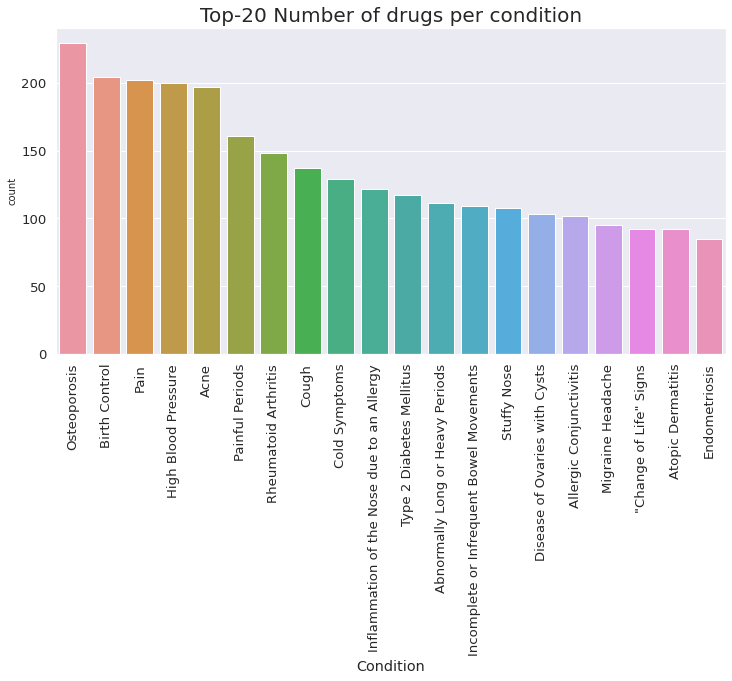

In [50]:
#lets check the number of drugs present in our dataset condition wise
conditions_gp = dataframe.groupby('Condition')['Drug'].nunique().sort_values(ascending=False)

#plot the top 20
# Setting the Parameter
condition_gp_top_20 = conditions_gp.head(20)
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [12, 6]
sns.barplot(x = condition_gp_top_20.index, y = condition_gp_top_20.values)
plt.title('Top-20 Number of drugs per condition',fontsize=20)
plt.xticks(rotation=90)
plt.ylabel('count',fontsize=10)
plt.show()

Checking if one medication can be used for multiple conditions.

In [51]:
#check the percentage of 'not listed / othe' conditions
#AFTER DELETING OTHER LISTED AS A CONDITION
#check the percentage of 'not listed / othe' conditions
not_listed2 = dataframe[dataframe['Condition'] == 'other']
print('Total length of the dataset : ', len(dataframe))
print('Number of not_listed values : ', len(not_listed2))
percent_not_listed = 100 * len(not_listed2)/dataframe.shape[0]
print('Total percent of noisy data {} %  '.format(percent_not_listed))

Total length of the dataset :  313011
Number of not_listed values :  0
Total percent of noisy data 0.0 %  


In [52]:
#let's check if a single drug is used for multiple conditions
drug_multiple_cond = dataframe.groupby('Drug')['Condition'].nunique().sort_values(ascending=False)
print(drug_multiple_cond.head(10))

Drug
prednisone                                                                         91
prednisone tablet, delayed release (enteric coated)                                91
prednisone concentrate                                                             91
cipro                                                                              58
cipro suspension, microcapsule reconstituted                                       58
methylprednisolone                                                                 51
ciprofloxacin                                                                      47
levaquin                                                                           45
kenalog-40 vial                                                                    42
doxycycline hyclate tablet, delayed release (enteric coated) antimalarial drugs    40
Name: Condition, dtype: int64


We can see that there are many medications that can be used for various different conditions.

In [53]:
#Multiple different conditions treated with different unique medications 
drug_multiple_cond = dataframe.groupby('Condition')['Drug'].nunique().sort_values(ascending=False)
print(drug_multiple_cond.head(10))

Condition
Osteoporosis                                  229
Birth Control                                 204
Pain                                          202
High Blood Pressure                           200
Acne                                          197
Painful Periods                               161
Rheumatoid Arthritis                          148
Cough                                         137
Cold Symptoms                                 129
Inflammation of the Nose due to an Allergy    122
Name: Drug, dtype: int64


Checking for which conditions is prednisone used, because is used for multiple conditions.

In [54]:
dataframe[dataframe['Drug'] == 'prednisone']['Condition'].unique()

array(['Inflammation of the Artery in the Temple Area',
       "Destruction of Red Blood Cells by Body's Own Antibodies",
       'Myasthenia Gravis', 'Muscle or Bone Disorder', 'Asthma',
       'Skin Rash with Sloughing', 'Sarcoidosis',
       'Disease in which Body has Immune Response Against Itself',
       'Inflammation of the Joints due to Gout', 'Rheumatoid Arthritis',
       'Contact Dermatitis', 'Lung Fibrosis',
       'Joint Disease which may include Attacks of Acute Arthritis',
       'Inflammation of Lung from Inhaling Something Irritating',
       'Inflammation of Skin and Muscles All Over the Body',
       'Muscle Pain and Stiffness in Shoulder, Neck and Pelvis',
       'Worsening of Asthma', "Crohn's Disease",
       'Acute Exacerbation of Multiple Sclerosis',
       'Pneumonia caused by Pneumocystis Jirovecii Organism',
       'Pneumonia with High Amount of Eosinophil White Blood Cells',
       'Prevention of Lung Transplant Rejection', 'Skin Condition',
       'Group of 

In [55]:
dataframe[dataframe['Drug'] == 'levaquin']['Condition'].unique()

array(['infection caused by bacteria', 'Pneumonia caused by Bacteria',
       'Bacterial Infection of Kidney due to E. Coli Organism',
       'Bacterial Infection with Bronchitis',
       'Acute Inflammation of the Maxillary Sinus',
       'Acute Maxillary Sinus H. Influenzae Bacteria Infection',
       'Urinary Tract Infection due to E. Coli Bacteria',
       'Bacterial Urinary Tract Infection',
       'Bronchitis caused by Haemophilus Parainfluenzae Bacteria',
       'Complicated Skin Infection',
       'Bacterial Pneumonia caused by Streptococcus',
       'Bacterial Pneumonia caused by Staphylococcus',
       'Bacterial Infection with Chronic Bronchitis',
       'Urinary Tract Infection caused by Klebsiella Bacteria',
       'Bronchitis caused by the Bacteria Streptococcus Pneumoniae',
       'Bacterial Stomach or Intestine Infection caused by Anthrax',
       'Infection of the Urinary Tract caused by Proteus Bacteria',
       'Bacterial Pneumonia caused by Streptococcus pneumoniae'

In [56]:
dataframe[dataframe['Condition'] == 'acne']['Drug'].unique()

array([], dtype=object)

In [57]:
#Lets see what cymbalta is used for as it was the top reviewed medicine mentioned and calculated above.
dataframe[dataframe['Drug'] == 'cymbalta']['Condition'].unique()

array(['Major Depressive Disorder', 'Repeated Episodes of Anxiety',
       'Anxiousness associated with Depression',
       'Chronic Muscle or Bone Pain', 'Neuropathic Pain',
       'Disorder characterized by Stiff, Tender & Painful Muscles',
       'Diabetic Complication causing Injury to some Body Nerves'],
      dtype=object)

In [58]:
dataframe[dataframe['Drug'] == 'lisinopril']['Condition'].unique()

array(['High Blood Pressure', 'Chronic Heart Failure',
       'Migraine Prevention',
       'Kidney Problem caused by Body Tissue Disease-Scleroderma',
       'Prevention of Recurrent Atrial Fibrillation',
       'Kidney Disease from Diabetes', 'Heart Attack',
       'Nondiabetic Proteinuric Nephropathy',
       'Failure of the Left Ventricle of the Heart',
       'Retinal Changes of Eye in a Patient with Diabetes',
       'Diastolic Heart Failure'], dtype=object)